# **SAE** : Modèle de Prédiction d'Âge et de Genre par Transfer Learning (Modèle 4)

Script complet pour l'entraînement d'un modèle de Deep Learning
(EfficientNetB3 en Transfer Learning) visant à prédire l'âge et le genre
à partir d'une image de visage (Dataset UTKFace).

Étapes :
1. Importation des bibliothèques et configuration
2. Chargement et exploration du dataset UTKFace
3. Prétraitement et création des tf.data Datasets
4. Construction du modèle (EfficientNetB3, multi-sorties)
5. Fonctions d'affichage des courbes d'entraînement
6. Entraînement progressif par dégel des couches
7. Évaluation sur des images de test
8. Analyse finale (confusion matrix, rapport de classification, etc.)
9. Sauvegarde du modèle et intégration à Gradio

# **SECTION 1 : Importation des bibliothèques et configuration initiale**

In [ ]:
# Installation du module Gradio (pour interface web) et mise à jour de TensorFlow
!pip install gradio --quiet
!pip install --upgrade tensorflow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 117.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.1 MB/s eta 0:00:00


In [ ]:
# Import des modules nécessaires
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, CSVLogger, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Application EfficientNetB3, et la fonction de preprocessing correspondante
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
# Montage Google Drive (pour l'environnement Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **SECTION 2 : Chargement et exploration des données UTKFace**

In [ ]:
# Décompression du dataset UTKFace depuis Google Drive
!unzip -qq /content/drive/MyDrive/UTKFace.zip -d UTKFace

In [ ]:
# Dictionnaire des chemins vers nos données.
# "full" : chemin où se trouvent toutes les images UTKFace
# "test" : dossier contenant des images de test externes
data_paths = {
    "full": "/content/UTKFace/UTKFace/",
    "test": "/content/drive/MyDrive/faces"  # dossier contenant des images tests externes
}

In [ ]:
# Dictionnaire pour l'interprétation des valeurs de genre
# On définit que 0 = "Male" et 1 = "Female" d'après le nom des fichiers UTKFace
genders = {0: "Male", 1: "Female"}

In [ ]:
# Paramètres d'entraînement
BATCH_SIZE = 64
IMG_SIZE = (128, 128)  # Dimensions d'entrée pour le réseau
IMG_SHAPE = IMG_SIZE + (3,)  # (128, 128, 3)

In [ ]:
def get_image(filepath):
    """
    Ouvre une image, convertit en RGB, redimensionne puis applique le
    prétraitement approprié à EfficientNet. Retourne un tableau NumPy.
    """
    image = Image.open(filepath).convert("RGB")
    image = image.resize(IMG_SIZE)
    image = np.array(image)
    # La fonction preprocess_input() applique une normalisation spécifique à EfficientNet
    image = preprocess_input(image)
    return image

def load_data_UTKFace(directory, stop=-1):
    """
    Charge les images et leurs labels (âge et genre) depuis le dossier UTKFace.
    - directory : dossier où se trouvent les images (format 'age_gender_...' pour le nom).
    - stop : permet de limiter la quantité d'images à charger (par défaut -1 => on charge tout).

    Les noms de fichier ont le format suivant :
      {age}_{gender}_{race}_{date}.jpg
    Exemple : 25_1_0_20170109150557335.jpg
      => age=25, gender=1 (female), race=0, etc.

    Retourne :
      - images : tableau NumPy des images prétraitées
      - age_y  : vecteur NumPy des âges
      - gender_y : vecteur NumPy des genres (0 ou 1)
    """
    images, age_y, gender_y = [], [], []
    files = os.listdir(directory)
    random.shuffle(files)  # On mélange la liste de fichiers pour échantillonner aléatoirement

    for file in tqdm(files):
        # Si stop != -1 et qu'on a déjà chargé 'stop' images, on arrête.
        if stop != -1 and len(age_y) >= stop:
            break
        try:
            # On extrait l'âge et le genre à partir du nom de fichier
            age, gender = map(int, file.split("_")[:2])
        except Exception as e:
            # Si le nom de fichier ne correspond pas au format attendu, on ignore
            continue

        # Charge l'image et l'ajoute aux tableaux
        images.append(get_image(os.path.join(directory, file)))
        age_y.append(age)
        gender_y.append(gender)

    return np.array(images), np.array(age_y), np.array(gender_y)

In [ ]:
# Chargement des données depuis le dossier "full"
images, age_y, gender_y = load_data_UTKFace(data_paths["full"])

100%|██████████| 23708/23708 [00:24<00:00, 967.87it/s]


In [ ]:
# On empile les labels dans une seule structure, sous forme [âge, genre]
labels = np.stack((age_y, gender_y), axis=1)

# Affichage du nombre total d'images chargées du dataset UTKFace.
print("Nombre total d'images chargées :", len(images))

Nombre total d'images chargées : 23708


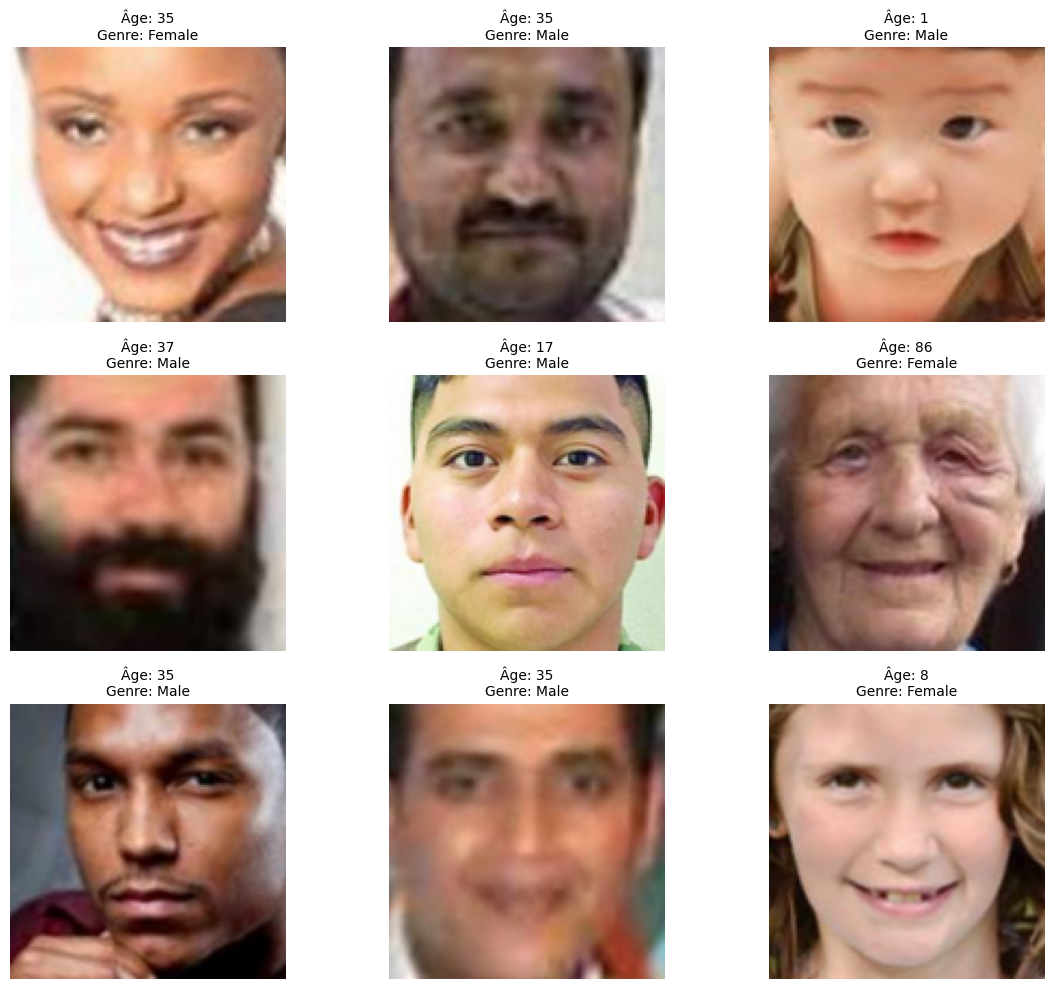

In [ ]:
def display_random_images(images, labels, num_images=9):
    """
    Affiche un échantillon aléatoire d'images du dataset avec âge et genre.
    - images : tableau NumPy (N, 128, 128, 3)
    - labels : tableau (N, 2) [âge, genre]
    - num_images : nombre d'images à afficher
    """
    indices = np.random.choice(len(images), num_images, replace=False)
    plt.figure(figsize=(12, 10))
    for i, idx in enumerate(indices):
        img = images[idx]
        age, gender = labels[idx]
        # Normalisation min-max uniquement pour l'affichage
        img_disp = (img - np.min(img)) / (np.max(img) - np.min(img))
        plt.subplot(3, 3, i+1)
        plt.imshow(img_disp)
        plt.title(f"Âge: {age}\nGenre: {genders[gender]}", fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Affichage d'un échantillon de 9 images au hasard avec leurs labels
display_random_images(images, labels)

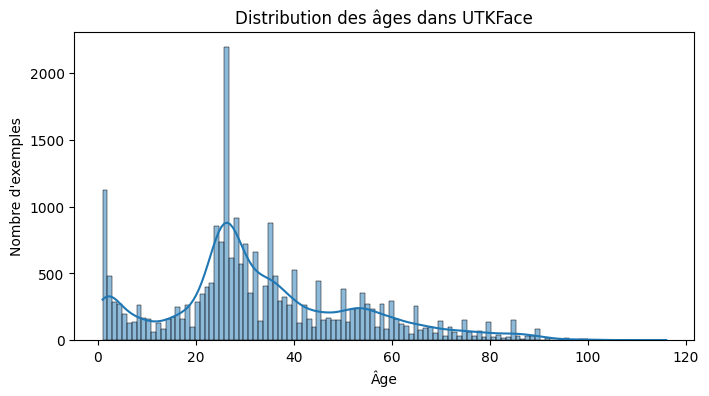

In [ ]:
# --- Statistiques sur le dataset : Distribution des âges ---
plt.figure(figsize=(8, 4))
sns.histplot(age_y, bins=max(age_y), kde=True, stat="count")
plt.xlabel("Âge")
plt.ylabel("Nombre d'exemples")
plt.title("Distribution des âges dans UTKFace")
plt.show()

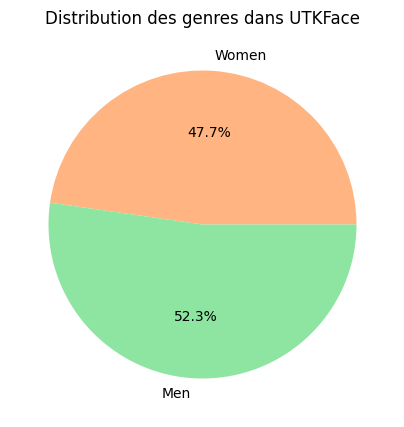

In [ ]:
# --- Statistiques : Distribution du genre ---
women = np.count_nonzero(gender_y)
men = len(gender_y) - women
plt.figure(figsize=(5, 5))
plt.pie(
    [women, men],
    labels=["Women", "Men"],
    colors=sns.color_palette("pastel")[1:3],
    autopct='%1.1f%%'
)
plt.title("Distribution des genres dans UTKFace")
plt.show()

In [ ]:
# Séparation du dataset en un ensemble d'entraînement (80%) et de validation (20%)
train_x, val_x, train_y, val_y = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

# **SECTION 3 : Prétraitement et création des datasets tf.data**

In [ ]:
def preprocess(image, label):
    """
    Fonction de prétraitement pour tf.data:
    - Redimensionne l'image à IMG_SIZE
    - Applique le preprocessing EfficientNet
    - Sépare les labels en (age, gender)
    Retourne (image, (age, gender)) pour l'entraînement.
    """
    image = tf.image.resize(image, IMG_SIZE)
    image = preprocess_input(image)
    age = label[0]
    gender = label[1]
    return image, (age, gender)

def create_dataset(images, labels, batch_size=32, training=True):
    """
    Convertit les arrays NumPy en un pipeline tf.data :
      - Conversion en tf.float32
      - Shuffle (uniquement si training=True)
      - Prétraitement (resize + normalize)
      - Application du Batch_Size
      - Mise en cache pour l'efficacité

    Retourne un objet tf.data.Dataset prêt pour model.fit().
    """
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(
        lambda img, lbl: (tf.cast(img, tf.float32), lbl),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if training:
        dataset = dataset.shuffle(1000)  # Mélange sur 1000 échantillons

    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache().prefetch(tf.data.AUTOTUNE)
    return dataset

# Création des datasets d'entraînement et de validation
train_dataset = create_dataset(train_x, train_y, BATCH_SIZE, training=True)
val_dataset   = create_dataset(val_x, val_y, BATCH_SIZE, training=False)

# **SECTION 4 : Construction du modèle à base de EfficientNetB3**

In [ ]:
# Data augmentation : on applique certaines transformations aléatoires
# (flip horizontal, rotation, zoom, contraste)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2)
], name="data_augmentation")

In [ ]:
# On charge un EfficientNetB3 pré-entraîné sur ImageNet, sans la couche de classification finale
base_model = EfficientNetB3(weights="imagenet", include_top=False, input_shape=IMG_SHAPE)

# Au départ, on gèle (freeze) toutes les couches pour ne pas modifier les poids
# du backbone pré-entraîné
base_model.trainable = False

print("Nombre de couches dans base_model :", len(base_model.layers))
base_model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Nombre de couches dans base_model : 385


Model: "efficientnetb3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 128, 128, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 128, 128, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 128, 128, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 129, 129, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 64, 64, 40)     │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 64, 64, 40)     │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 64, 64, 40)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 64, 64, 40)     │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 64, 64, 40)     │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 64, 64, 40)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 10,783,535 (41.14 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 10,783,535 (41.14 MB)

In [ ]:
# Construction de la tête du réseau pour la régression d'âge et la classification de genre
inputs = tf.keras.Input(shape=IMG_SHAPE, name="input_image")

# On applique la data augmentation sur l'entrée
x = data_augmentation(inputs)

# Par sécurité, on applique aussi le preprocess_input, même si on l'a déjà fait.
# (Ici, il sert plutôt si on fait le fine-tuning "en direct".)
x = preprocess_input(x)

# Passage par EfficientNetB3 en mode "inférence" (training=False pour éviter les effets BN/Dropout)
x = base_model(x, training=False)

# GlobalAveragePooling2D pour compresser spatialement les features
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Dense intermédiaire pour apprendre des représentations plus spécifiques
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)

In [ ]:
# --------------------- Branche pour la prédiction de l'âge ---------------------
age_branch = tf.keras.layers.Dense(256, activation="relu")(x)
age_branch = tf.keras.layers.BatchNormalization()(age_branch)
age_branch = tf.keras.layers.Dropout(0.4)(age_branch)
# Sortie "âge" : activation linéaire (on prédit une valeur continue)
outputs_age = tf.keras.layers.Dense(1, activation="linear", name="age")(age_branch)

In [ ]:
# --------------------- Branche pour la prédiction du genre ---------------------
gender_branch = tf.keras.layers.Dense(256, activation="relu")(x)
gender_branch = tf.keras.layers.BatchNormalization()(gender_branch)
gender_branch = tf.keras.layers.Dropout(0.4)(gender_branch)
# Sortie "genre" : activation sigmoid pour binaire (0=Male, 1=Female)
outputs_gender = tf.keras.layers.Dense(1, activation="sigmoid", name="gender")(gender_branch)

In [ ]:
# On combine les deux branches dans un seul modèle fonctionnel Keras
model = tf.keras.Model(inputs=inputs, outputs=[outputs_age, outputs_gender])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ data_augmentation         │ (None, 128, 128, 3)    │              0 │ input_image[0][0]      │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb3            │ (None, 4, 4, 1536)     │     10,783,535 │ data_augmentation[0][… │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1536)           │              0 │ efficientnetb3[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │        786,944 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        131,328 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │        131,328 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256)            │          1,024 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256)            │          1,024 │ dense_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age (Dense)               │ (None, 1)              │            257 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender (Dense)            │ (None, 1)              │            257 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,835,697 (45.15 MB)

 Trainable params: 1,051,138 (4.01 MB)

 Non-trainable params: 10,784,559 (41.14 MB)

# **SECTION 5 : Fonctions d'affichage des courbes d'entraînement**

In [ ]:
def plot_training_history_separate(history, phase_name):
    """
    Affiche 3 courbes séparées pour l'entraînement :
      - MAE sur l'âge
      - Accuracy sur le genre
      - Loss globale
    Les métriques sont récupérées depuis l'objet 'history' retourné par model.fit().
    """
    epochs = range(1, len(history.history['loss']) + 1)

    # Graphique pour la MAE (âge)
    plt.figure(figsize=(6, 5))
    plt.plot(epochs, history.history['age_mae'], label='Train Age MAE')
    plt.plot(epochs, history.history['val_age_mae'], label='Val Age MAE')
    plt.xlabel("Epochs")
    plt.ylabel("Age MAE")
    plt.title(f"{phase_name} - Age MAE")
    plt.legend()
    plt.show()

    # Graphique pour l'accuracy (genre)
    plt.figure(figsize=(6, 5))
    plt.plot(epochs, history.history['gender_accuracy'], label='Train Gender Accuracy')
    plt.plot(epochs, history.history['val_gender_accuracy'], label='Val Gender Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Gender Accuracy")
    plt.title(f"{phase_name} - Gender Accuracy")
    plt.legend()
    plt.show()

    # Graphique pour la loss globale
    plt.figure(figsize=(6, 5))
    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Val Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{phase_name} - Overall Loss")
    plt.legend()
    plt.show()

# **SECTION 6 : Entraînement du modèle en plusieurs phases**

In [ ]:
# On définit une liste de callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5),
    ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True)
]

# Nombre total de couches dans EfficientNetB3
total_layers = len(base_model.layers)

# Nombre de phases (ici 5) pour débloquer progressivement les couches
# On peut augmenter ce nombre si on veut un dégel plus progressif.
num_phases = 6

Phase 1 : Débloquer les 64 dernières couches sur 385
Utilisation d'un learning rate de 0.001 pour la phase 1
Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 84s 180ms/step - age_loss: 30.6829 - age_mae: 30.6830 - gender_accuracy: 0.7597 - gender_loss: 0.5341 - loss: 164.0980 - val_age_loss: 11.3169 - val_age_mae: 11.3867 - val_gender_accuracy: 0.8659 - val_gender_loss: 0.3759 - val_loss: 64.4940 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 44s 148ms/step - age_loss: 10.4922 - age_mae: 10.4922 - gender_accuracy: 0.8418 - gender_loss: 0.3649 - loss: 59.7585 - val_age_loss: 9.7551 - val_age_mae: 9.7831 - val_gender_accuracy: 0.8703 - val_gender_loss: 0.3266 - val_loss: 55.4933 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 42s 142ms/step - age_loss: 8.3673 - age_mae: 8.3673 - gender_accuracy: 0.8549 - gender_loss: 0.3304 - loss: 48.4441 - val_age_loss: 13.9406 - val_age_mae: 13.9831 - val_gender_accuracy: 0.8657 - val_gender_loss: 0.3573 - val_loss: 77.0876 - l

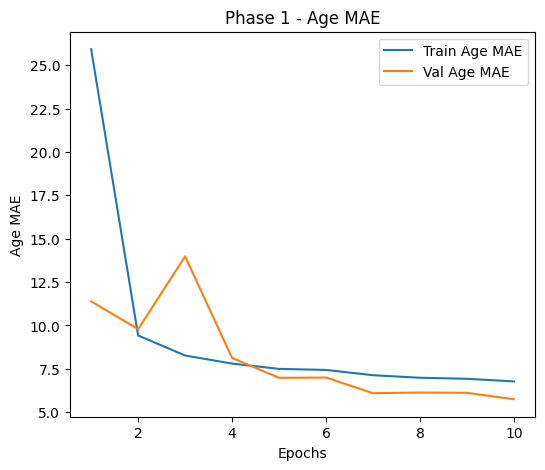

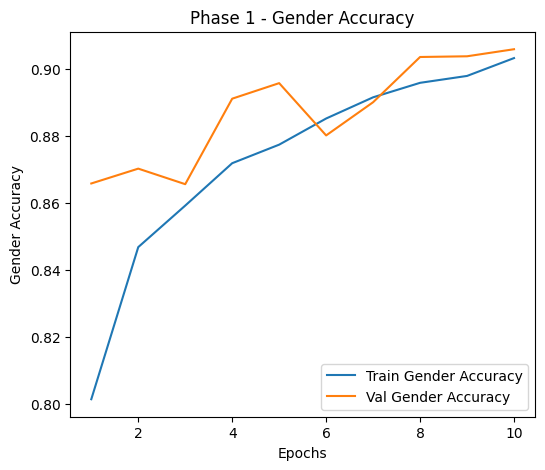

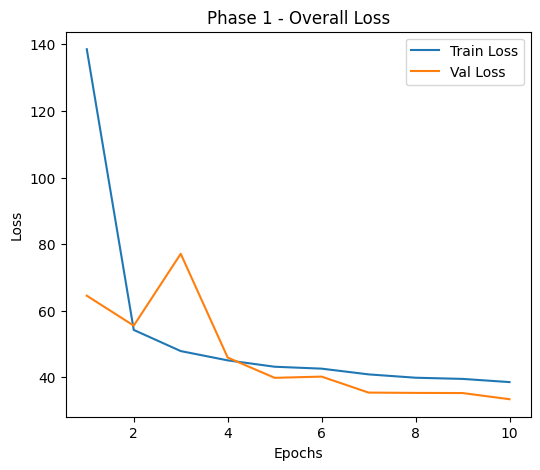

Phase 2 : Débloquer les 128 dernières couches sur 385
Utilisation d'un learning rate de 0.0005 pour la phase 2
Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 91s 183ms/step - age_loss: 7.3129 - age_mae: 7.3129 - gender_accuracy: 0.8908 - gender_loss: 0.2660 - loss: 41.8851 - val_age_loss: 6.5344 - val_age_mae: 6.4898 - val_gender_accuracy: 0.9024 - val_gender_loss: 0.2444 - val_loss: 37.3854 - learning_rate: 5.0000e-04
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 50s 169ms/step - age_loss: 6.7163 - age_mae: 6.7163 - gender_accuracy: 0.9017 - gender_loss: 0.2383 - loss: 38.3485 - val_age_loss: 6.3427 - val_age_mae: 6.3615 - val_gender_accuracy: 0.8853 - val_gender_loss: 0.3630 - val_loss: 39.1390 - learning_rate: 5.0000e-04
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 52s 176ms/step - age_loss: 6.3420 - age_mae: 6.3420 - gender_accuracy: 0.9116 - gender_loss: 0.2225 - loss: 36.1611 - val_age_loss: 5.6926 - val_age_mae: 5.7091 - val_gender_accuracy: 0.9110 - val_gender_loss: 0.2091 - val_loss: 32.7711 - 

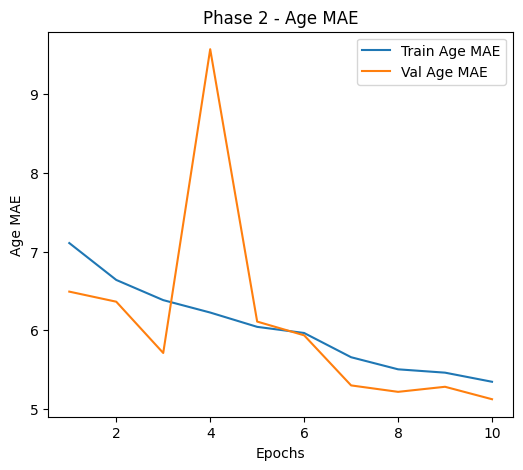

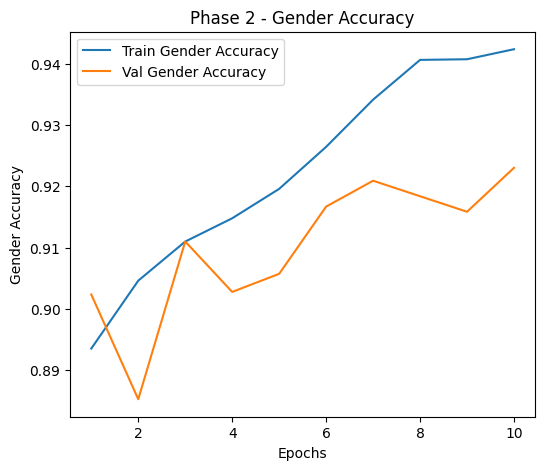

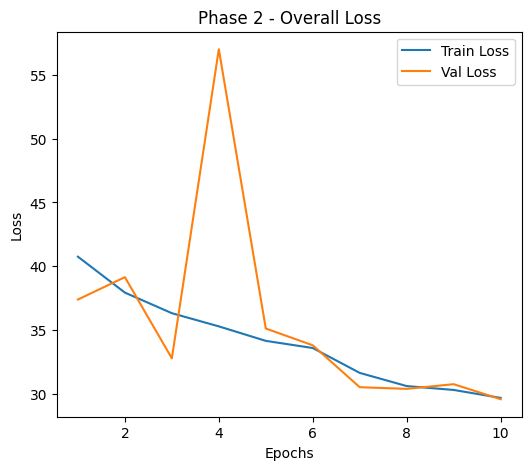

Phase 3 : Débloquer les 192 dernières couches sur 385
Utilisation d'un learning rate de 0.00025 pour la phase 3
Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 116s 233ms/step - age_loss: 5.7138 - age_mae: 5.7138 - gender_accuracy: 0.9344 - gender_loss: 0.1712 - loss: 31.9937 - val_age_loss: 6.1766 - val_age_mae: 6.2030 - val_gender_accuracy: 0.9228 - val_gender_loss: 0.2233 - val_loss: 35.5329 - learning_rate: 2.5000e-04
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 64s 217ms/step - age_loss: 5.4165 - age_mae: 5.4165 - gender_accuracy: 0.9447 - gender_loss: 0.1399 - loss: 29.8808 - val_age_loss: 5.5981 - val_age_mae: 5.6081 - val_gender_accuracy: 0.9190 - val_gender_loss: 0.2198 - val_loss: 32.4885 - learning_rate: 2.5000e-04
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 64s 217ms/step - age_loss: 5.2538 - age_mae: 5.2538 - gender_accuracy: 0.9485 - gender_loss: 0.1355 - loss: 28.9779 - val_age_loss: 5.4566 - val_age_mae: 5.4659 - val_gender_accuracy: 0.9175 - val_gender_loss: 0.2243 - val_loss: 31.8582 

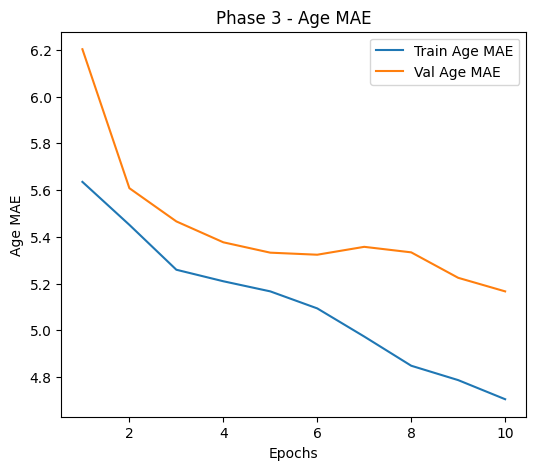

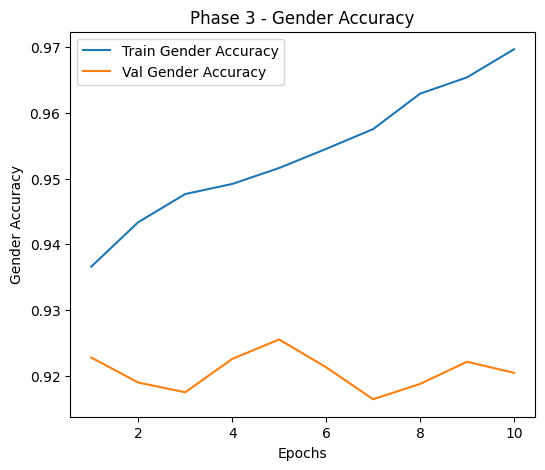

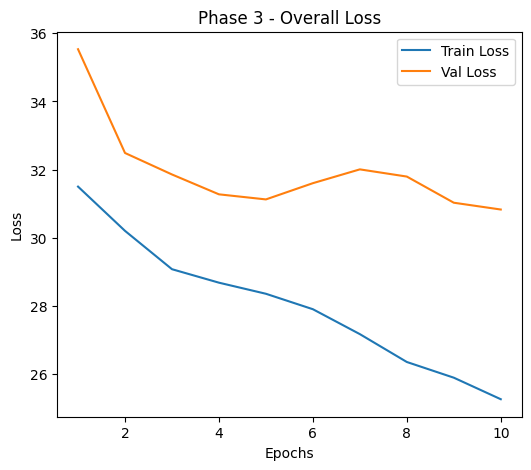

Phase 4 : Débloquer les 256 dernières couches sur 385
Utilisation d'un learning rate de 0.000125 pour la phase 4
Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 133s 262ms/step - age_loss: 4.8292 - age_mae: 4.8292 - gender_accuracy: 0.9622 - gender_loss: 0.0967 - loss: 26.0811 - val_age_loss: 5.4561 - val_age_mae: 5.4291 - val_gender_accuracy: 0.9232 - val_gender_loss: 0.2442 - val_loss: 32.0888 - learning_rate: 1.2500e-04
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 73s 246ms/step - age_loss: 4.6703 - age_mae: 4.6703 - gender_accuracy: 0.9680 - gender_loss: 0.0844 - loss: 25.0391 - val_age_loss: 5.2864 - val_age_mae: 5.2797 - val_gender_accuracy: 0.9207 - val_gender_loss: 0.2616 - val_loss: 31.6936 - learning_rate: 1.2500e-04
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 73s 245ms/step - age_loss: 4.6179 - age_mae: 4.6179 - gender_accuracy: 0.9721 - gender_loss: 0.0782 - loss: 24.6534 - val_age_loss: 5.4189 - val_age_mae: 5.4013 - val_gender_accuracy: 0.9203 - val_gender_loss: 0.2663 - val_loss: 32.3971

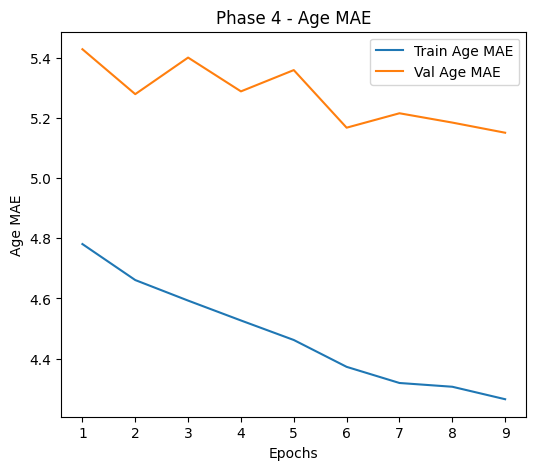

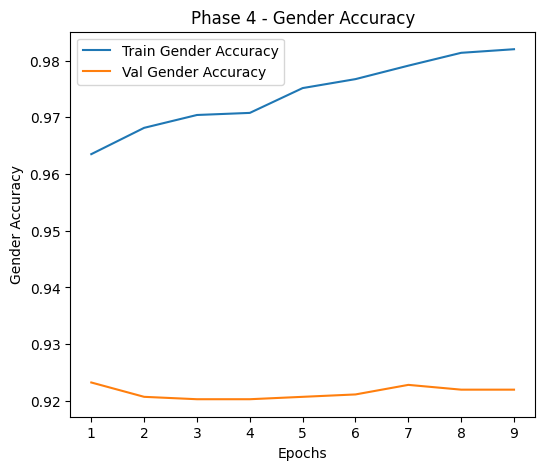

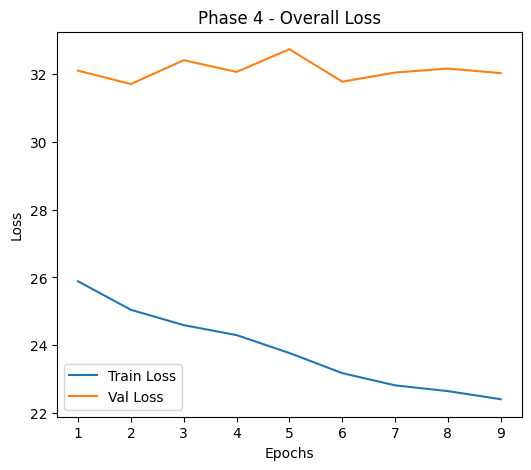

Phase 5 : Débloquer les 320 dernières couches sur 385
Utilisation d'un learning rate de 6.25e-05 pour la phase 5
Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 156s 310ms/step - age_loss: 4.7864 - age_mae: 4.7864 - gender_accuracy: 0.9642 - gender_loss: 0.0970 - loss: 25.8727 - val_age_loss: 5.3295 - val_age_mae: 5.3166 - val_gender_accuracy: 0.9213 - val_gender_loss: 0.2580 - val_loss: 31.8049 - learning_rate: 6.2500e-05
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 88s 298ms/step - age_loss: 4.6990 - age_mae: 4.6990 - gender_accuracy: 0.9717 - gender_loss: 0.0811 - loss: 25.1176 - val_age_loss: 5.3101 - val_age_mae: 5.2929 - val_gender_accuracy: 0.9230 - val_gender_loss: 0.2596 - val_loss: 31.7194 - learning_rate: 6.2500e-05
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 89s 299ms/step - age_loss: 4.5353 - age_mae: 4.5352 - gender_accuracy: 0.9725 - gender_loss: 0.0764 - loss: 24.2047 - val_age_loss: 5.1752 - val_age_mae: 5.1520 - val_gender_accuracy: 0.9258 - val_gender_loss: 0.2589 - val_loss: 31.0019

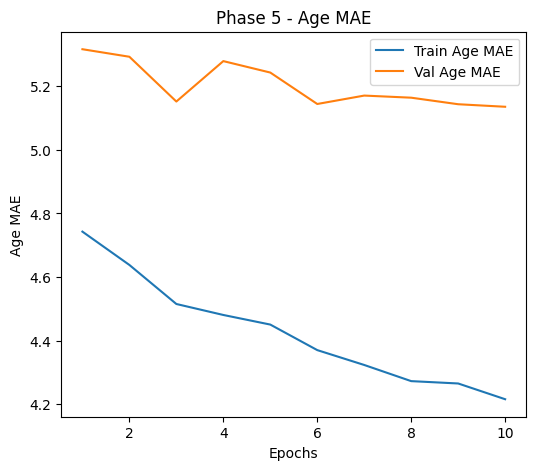

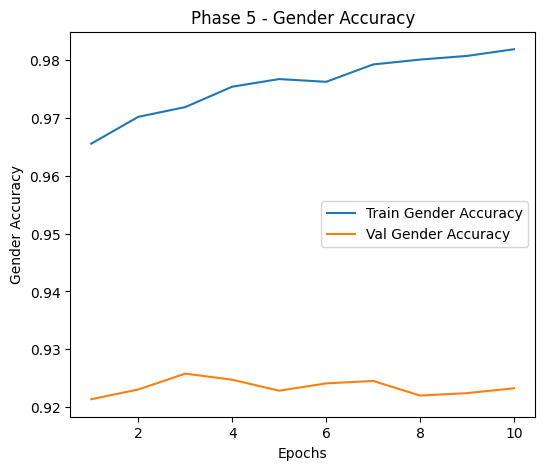

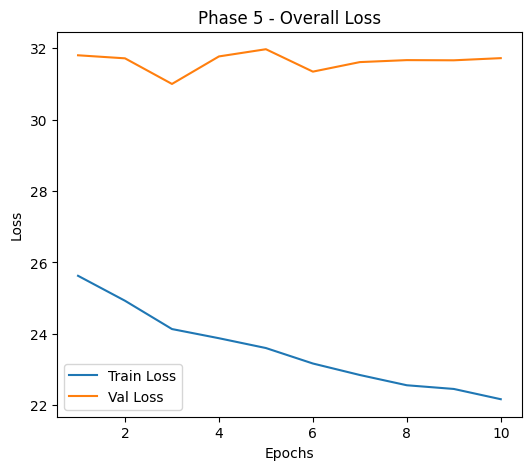

Phase 6 : Débloquer les 385 dernières couches sur 385
Utilisation d'un learning rate de 3.125e-05 pour la phase 6
Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 211s 456ms/step - age_loss: 4.8617 - age_mae: 4.8616 - gender_accuracy: 0.9620 - gender_loss: 0.1078 - loss: 26.4649 - val_age_loss: 5.3158 - val_age_mae: 5.2938 - val_gender_accuracy: 0.9201 - val_gender_loss: 0.2777 - val_loss: 32.0236 - learning_rate: 3.1250e-05
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 132s 443ms/step - age_loss: 4.7261 - age_mae: 4.7260 - gender_accuracy: 0.9657 - gender_loss: 0.0932 - loss: 25.4939 - val_age_loss: 5.3474 - val_age_mae: 5.3265 - val_gender_accuracy: 0.9222 - val_gender_loss: 0.2694 - val_loss: 32.0870 - learning_rate: 3.1250e-05
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 132s 444ms/step - age_loss: 4.7018 - age_mae: 4.7018 - gender_accuracy: 0.9705 - gender_loss: 0.0852 - loss: 25.2122 - val_age_loss: 5.3238 - val_age_mae: 5.3174 - val_gender_accuracy: 0.9205 - val_gender_loss: 0.2726 - val_loss: 32.1

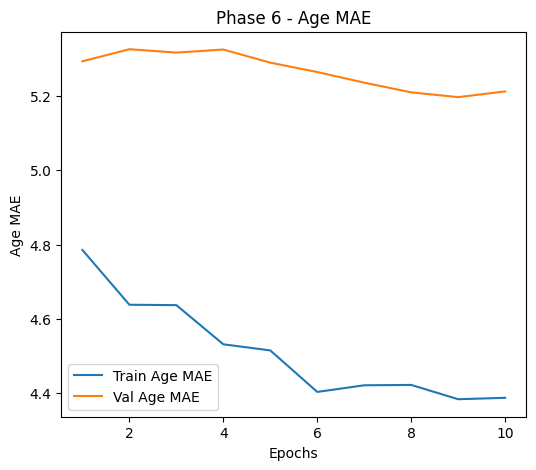

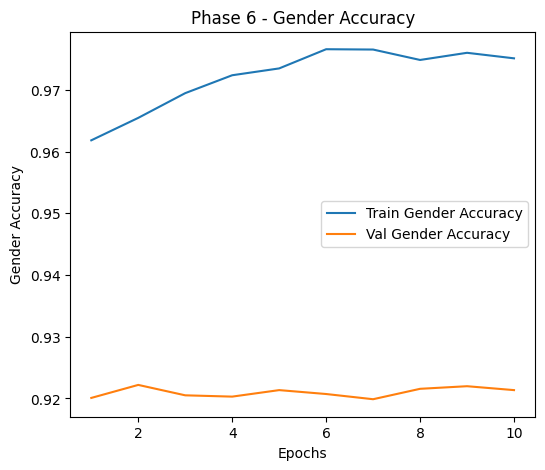

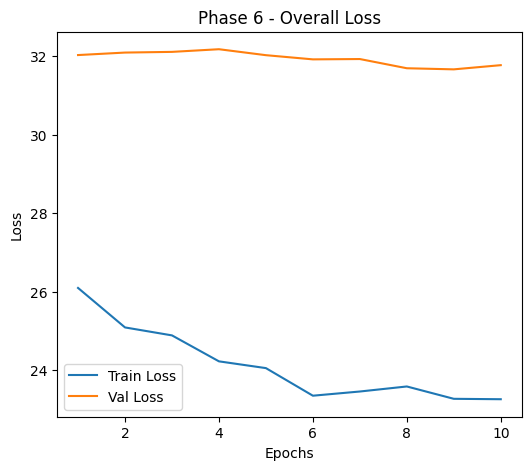

In [ ]:
for phase in range(1, num_phases + 1):
    # On calcule combien de couches débloquer (ici proportionnel à la phase)
    num_layers_to_unfreeze = int((phase / num_phases) * total_layers)
    print(f"Phase {phase} : Débloquer les {num_layers_to_unfreeze} dernières couches sur {total_layers}")

    # On parcourt toutes les couches et on définit .trainable=True
    # uniquement pour les couches concernées
    for i, layer in enumerate(base_model.layers):
        layer.trainable = (i >= total_layers - num_layers_to_unfreeze)

    # On ajuste un learning rate (LR) exponentiellement décroissant à chaque phase
    lr = 1e-3 * (0.5 ** (phase - 1))
    print(f"Utilisation d'un learning rate de {lr} pour la phase {phase}")

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)

    # Pour la compilation, on définit deux pertes (age et gender),
    # ainsi que leurs poids respectifs.
    model.compile(
        optimizer=optimizer,
        loss={"gender": "binary_crossentropy", "age": "mean_absolute_error"},
        metrics={"gender": "accuracy", "age": "mae"},
        loss_weights={"age": 5, "gender": 20}  # Ajuster ces poids selon l'importance relative des tâches
    )

    # Entraînement pour quelques époques (ou on laisse EarlyStopping gérer l'arrêt)
    history_phase = model.fit(
        train_dataset,
        epochs=10,
        validation_data=val_dataset,
        callbacks=callbacks
    )

    # Visualisation des courbes d'apprentissage pour cette phase
    plot_training_history_separate(history_phase, f"Phase {phase}")

# **SECTION 7 : Évaluation sur des images de test**

In [ ]:
def test_images(directory, model, images_x=3, images_y=3):
    """
    Sélectionne aléatoirement quelques images depuis 'directory',
    tente de parser l'âge et le genre réel via le nom du fichier,
    et affiche la prédiction du modèle.
    """
    plt.figure(figsize=(15, 7))
    files = os.listdir(directory)
    random.shuffle(files)

    for i, file in enumerate(files[:images_x * images_y]):
        try:
            # On essaie de récupérer âge et genre réels depuis le nom du fichier
            actual_age, actual_gender = map(int, file.split("_")[:2])
        except:
            # Si le nom de fichier n'a pas le format attendu, on skip
            continue

        # Chargement et affichage
        image = get_image(os.path.join(directory, file))
        plt.subplot(images_y, images_x, i + 1)
        plt.axis("off")
        img_disp = (image - np.min(image)) / (np.max(image) - np.min(image))
        plt.imshow(img_disp)

        # Prédiction : le modèle renvoie [age_pred, gender_pred]
        prediction = model.predict(np.expand_dims(image, axis=0))
        pred_age = np.round(prediction[0][0]).item()   # Arrondir l'âge
        pred_gender = np.round(prediction[1][0]).item()  # 0 ou 1

        plt.title(
            f"Âge réel: {actual_age} / Préd: {pred_age}\n"
            f"Genre réel: {genders[actual_gender]} / Préd: {genders[pred_gender]}",
            fontsize=8
        )

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


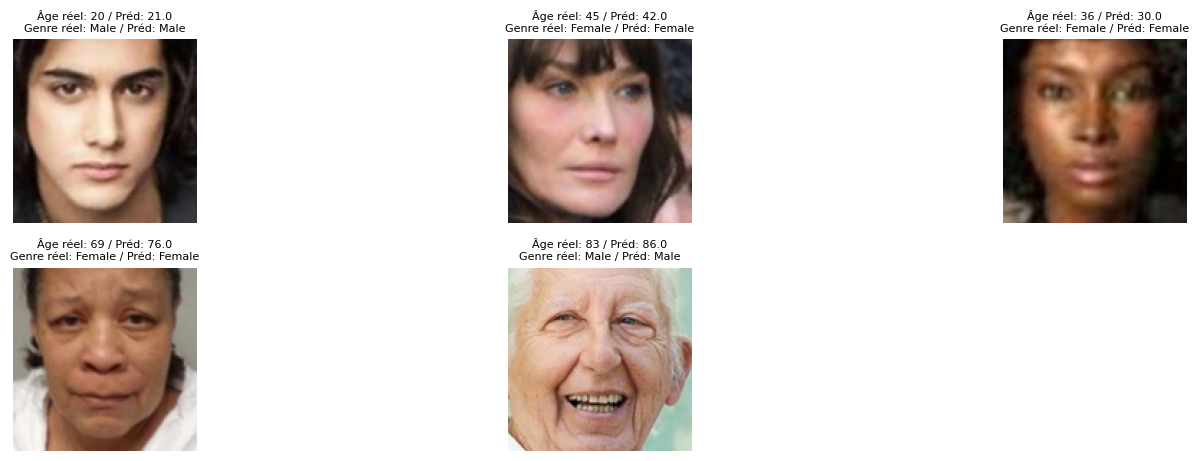

In [ ]:
# Test sur le dossier défini dans data_paths["test"] (s'il contient des images)
test_images(data_paths["test"], model)

# **SECTION 8 : Rapport final et analyse du modèle**

In [ ]:
# Évaluation globale sur l'ensemble de validation (retourne [loss, age_loss, gender_loss, age_mae, gender_accuracy, ...])
evaluation = model.evaluate(val_dataset)
print("\nÉvaluation finale sur l'ensemble de validation :")
print(evaluation)

75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - age_loss: 5.2546 - age_mae: 5.2540 - gender_accuracy: 0.9176 - gender_loss: 0.2920 - loss: 32.1110

Évaluation finale sur l'ensemble de validation :
[31.659664154052734, 5.220958709716797, 0.2802378237247467, 5.197289943695068, 0.9219738245010376]


In [ ]:
# Pour une analyse plus détaillée, on récupère toutes les prédictions sur la validation
all_true_age = []
all_true_gender = []
all_pred_age = []
all_pred_gender = []

for images_batch, (age_batch, gender_batch) in val_dataset:
    preds = model.predict(images_batch)
    pred_age_batch = preds[0].flatten()
    pred_gender_batch = preds[1].flatten()
    all_true_age.extend(age_batch.numpy())
    all_true_gender.extend(gender_batch.numpy())
    all_pred_age.extend(pred_age_batch)
    all_pred_gender.extend(pred_gender_batch)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━

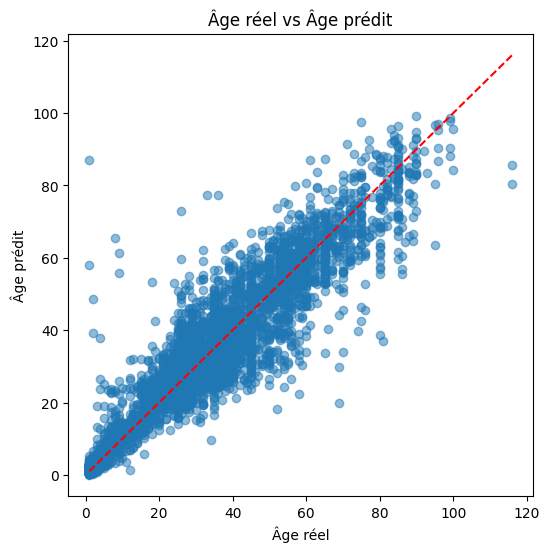

In [ ]:
# --- Analyse de la régression d'âge ---
plt.figure(figsize=(6, 6))
plt.scatter(all_true_age, all_pred_age, alpha=0.5)
# On trace la diagonale idéale y=x en rouge pointillé
plt.plot([min(all_true_age), max(all_true_age)], [min(all_true_age), max(all_true_age)], 'r--')
plt.xlabel("Âge réel")
plt.ylabel("Âge prédit")
plt.title("Âge réel vs Âge prédit")
plt.show()

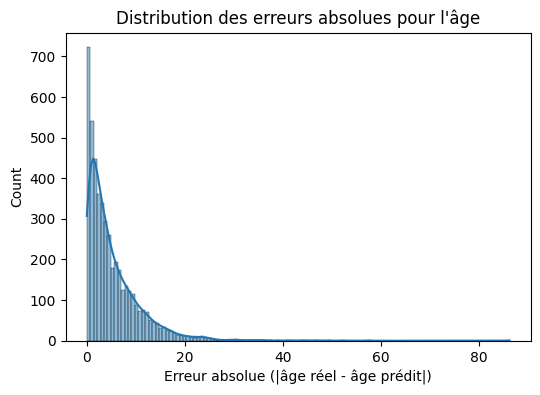

In [ ]:
# Distribution des erreurs absolues en âge
age_errors = np.abs(np.array(all_true_age) - np.array(all_pred_age))
plt.figure(figsize=(6, 4))
sns.histplot(age_errors, kde=True)
plt.xlabel("Erreur absolue (|âge réel - âge prédit|)")
plt.title("Distribution des erreurs absolues pour l'âge")
plt.show()

In [ ]:
# --- Analyse de la classification de genre ---
# On binarise la prédiction : seuil 0.5
all_pred_gender_labels = [1 if p >= 0.5 else 0 for p in all_pred_gender]

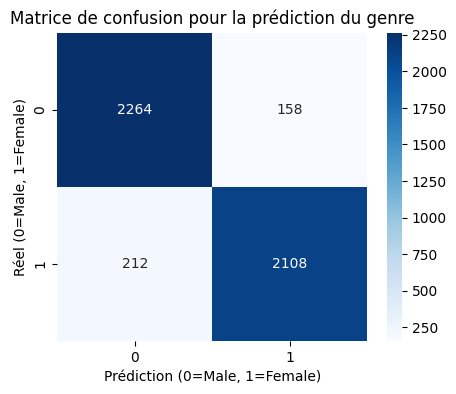

In [ ]:
# Matrice de confusion
cm = confusion_matrix(all_true_gender, all_pred_gender_labels)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédiction (0=Male, 1=Female)")
plt.ylabel("Réel (0=Male, 1=Female)")
plt.title("Matrice de confusion pour la prédiction du genre")
plt.show()

In [ ]:
# Rapport de classification
print("Rapport de classification pour le genre :")
print(classification_report(all_true_gender, all_pred_gender_labels, target_names=["Male", "Female"]))

Rapport de classification pour le genre :
              precision    recall  f1-score   support

        Male       0.91      0.93      0.92      2422
      Female       0.93      0.91      0.92      2320

    accuracy                           0.92      4742
   macro avg       0.92      0.92      0.92      4742
weighted avg       0.92      0.92      0.92      4742



# **SECTION 9 : Sauvegarde du modèle final**

In [ ]:
model.save("final_model.keras")
print("Modèle final sauvegardé au format .keras")

Modèle final sauvegardé au format .keras


In [ ]:
# 0. On défini weighted_mae
# On recrée la variable "age_weights" à l'identique.

import numpy as np
import gradio as gr
# On crée un age_weights bidon (identique au script original).
max_age = 116
age_weights_array = np.ones(max_age+1, dtype=np.float32)
# Dans le code, tu avais:
# age_counts = np.bincount(age_y)
# age_weights = 1 / np.maximum(age_counts, 1)
# age_weights /= np.max(age_weights)

#donc
def weighted_mae(y_true, y_pred):
    age_bin = tf.cast(y_true, tf.int32)
    age_bin_clipped = tf.clip_by_value(age_bin, 0, max_age)
    # On rassemble les poids
    w = tf.gather(tf.constant(age_weights_array, dtype=tf.float32), age_bin_clipped)
    return tf.keras.mean(w * tf.keras.abs(y_true - y_pred))


# 1. Chargement des modèles


# Modèle 1
#model1 = tf.keras.models.load_model("model_v2_Q1.keras")
# Modèle 2
#model2 = tf.keras.models.load_model("model_v2_Q2.keras")
# Modèle 4 (avec custom_objects)
model4 = tf.keras.models.load_model("/content/drive/MyDrive/Model_4.keras")

# 2. Fonctions de prétraitement

def preprocess_128(img_pil):
    """ Redimensionne en 128x128, normalise et retourne shape (1,128,128,3). """
    img = img_pil.resize((128, 128))
    img = np.array(img).astype(np.float32) / 255.0
    if img.shape[-1] == 4:
        img = img[..., :3]
    return np.expand_dims(img, axis=0)

def preprocess(image):
    """
    Fonction de prétraitement pour tf.data:
    - Redimensionne l'image à IMG_SIZE
    - Applique le preprocessing EfficientNet
    - Sépare les labels en (age, gender)
    Retourne (image, (age, gender)) pour l'entraînement.
    """
    image = tf.image.resize(image, (128,128))
    image = preprocess_input(image)
    return image

# 3a. Interface du Modèle 1

'''def predict_model1(image):
    if image is None:
        return "Veuillez charger une image."
    x = preprocess_64(image)
    pred = model1.predict(x)[0][0]  # prob
    gender = "Homme" if pred >= 0.5 else "Femme"
    return f"Genre prédit : {gender}"

model1_interface = gr.Interface(
    fn=predict_model1,
    inputs=gr.Image(type="pil"),
    outputs=gr.Textbox(label="Résultat - Modèle 1"),
    title="Modèle 1 - Classification de Genre",
    description="Redimension 64x64, classification binaire (homme/femme)."
)


# 3b. Interface du Modèle 2

def predict_model2(image):
    if image is None:
        return "Veuillez charger une image."
    x = preprocess_64(image)
    pred = model2.predict(x)[0][0]
    age = round(float(pred), 1)
    return f"Âge prédit : {age}"

model2_interface = gr.Interface(
    fn=predict_model2,
    inputs=gr.Image(type="pil"),
    outputs=gr.Textbox(label="Résultat - Modèle 2"),
    title="Modèle 2 - Régression d'Âge",
    description="Redimension 64x64, régression sur l'âge."
)'''

# 3c. Interface du Modèle 4

def predict_model4(image):
    """
    Le modèle 4 renvoie [outputs_age, outputs_gender].
    """
    if image is None:
        return "Veuillez charger une image."
    x = preprocess(image)
    preds = model4.predict(x)
    # preds[0] => âge, preds[1] => genre
    pred_age = preds[0][0][0]
    pred_gender = preds[1][0][0]
    age = round(float(pred_age), 1)
    gender = "Homme" if pred_gender >= 0.5 else "Femme"
    return f"Âge prédit : {age}\nGenre prédit : {gender}"

model4_interface = gr.Interface(
    fn=predict_model4,
    inputs=gr.Image(type="pil"),
    outputs=gr.Textbox(label="Résultats - Modèle 4"),
    title="Modèle 4 - Age + Genre (CNN EfficientNetB3)",
    description="Redimension 128x128, multi-sorties : âge + genre."
)
# 4. On regroupe les 3 interfaces  dans des onglets

demo = gr.TabbedInterface(
    [model4_interface],
    ["Multi Age+Genre (Partie 4)"]
)

if __name__ == "__main__":
  demo.launch(server_name="0.0.0.0", server_port=7865, debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://02d931e58b9daf05c4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 2108, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 1655, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
           ^^^^^^^^^^

Keyboard interruption in main thread... closing server.
Killing tunnel 0.0.0.0:7865 <> https://02d931e58b9daf05c4.gradio.live
